In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from torchvision import models,transforms
import torch.nn as nn
import torch.utils.data as Data
import os

import cv2
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")


In [12]:
import pandas as pd

data_path = './input/plant-pathology-2021-fgvc8/'

train = pd.read_csv(data_path + 'train.csv')
# test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [13]:
train.shape

(18632, 2)

In [14]:
train.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [15]:
train['labels'].value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

In [16]:
submission.head()

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [36]:
from collections import defaultdict


dct = defaultdict(list)

for i, label in enumerate(train.labels):
    for category in label.split():
        dct[category].append(i)
 
dct = {key: np.array(val) for key, val in dct.items()}

In [37]:
new_df = pd.DataFrame(np.zeros((train.shape[0], len(dct.keys())), dtype=np.int8), columns=dct.keys())

for key, val in dct.items():
    new_df.loc[val, key] = 1
    
train = pd.concat([train, new_df], axis=1)
train.head()

,image,labels,healthy,scab,frog_eye_leaf_spot,complex,rust,powdery_mildew
0,800113bb65efe69e.jpg,healthy,1,0,0,0,0,0
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,0,1,1,1,0,0
2,80070f7fb5e2ccaa.jpg,scab,0,1,0,0,0,0
3,80077517781fb94f.jpg,scab,0,1,0,0,0,0
4,800cbf0ff87721f8.jpg,complex,0,0,0,1,0,0


In [26]:
train_image_path = './input/plant-pathology-2021-fgvc8/train_images'
test_image_path = './input/plant-pathology-2021-fgvc8/test_images'
train_df_path = './input/plant-pathology-2021-fgvc8/train.csv'
test_df_path = './input/plant-pathology-2021-fgvc8/sample_submission.csv'

### 12.2.2 데이터 시각화

타깃값 분포

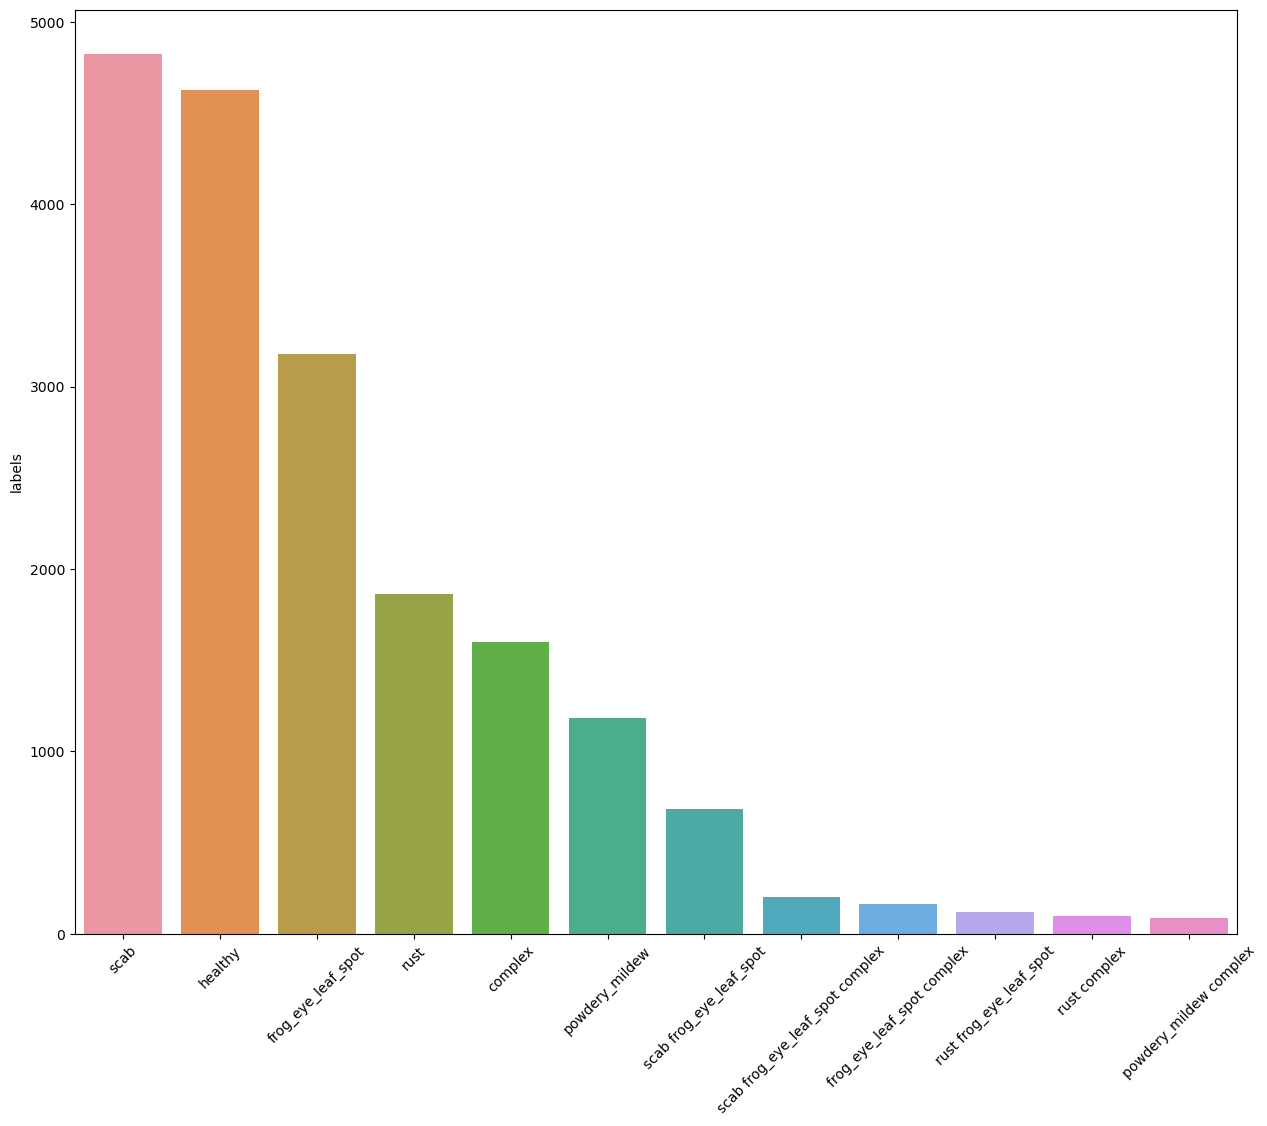

In [18]:
plt.figure(figsize=(15,12))
labels = sns.barplot(train.labels.value_counts().index,train.labels.value_counts())
for item in labels.get_xticklabels():
    item.set_rotation(45)

In [9]:
healthy.shape, multiple_diseases.shape, rust.shape, scab.shape

((516, 5), (91, 5), (622, 5), (592, 5))

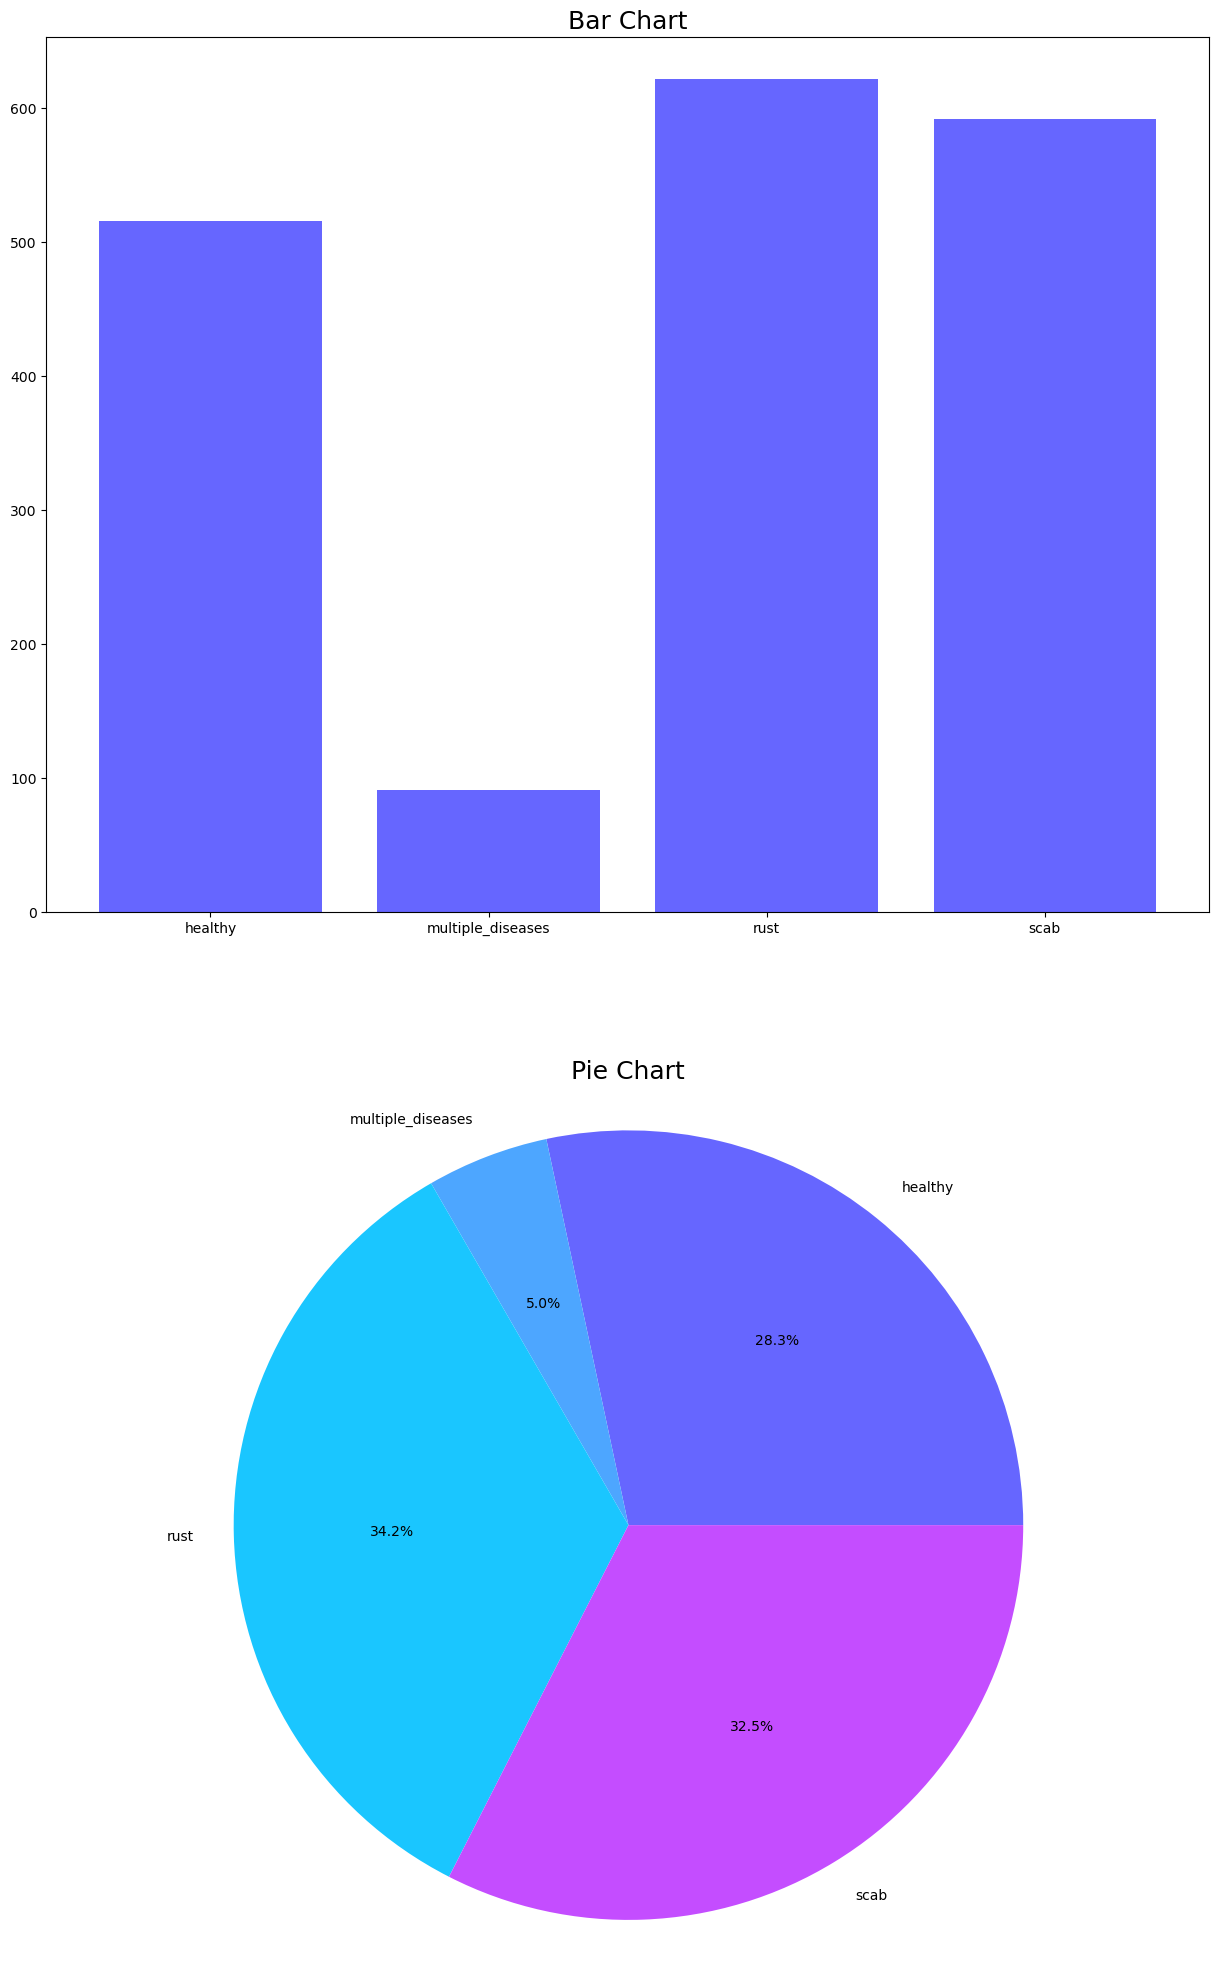

In [10]:
diseases = dict()

for column in ["healthy","multiple_diseases","rust","scab"]:
    counts = pd.DataFrame(train[column].value_counts())
    diseases[column] = counts.iloc[1,0]
    
#bar chart to show different diseases    
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(15,25))
ax1.bar(diseases.keys(),diseases.values(), color=["#6666ff"])
ax1.set_title('Bar Chart', fontsize=18)

ax2.pie(diseases.values(),labels = diseases.keys(), colors=["#6666ff","#4da6ff","#1ac6ff","#c44dff"], autopct='%1.1f%%')
ax2.set_title('Pie Chart', fontsize=18)
ax2.axis('equal') 

plt.show()

In [20]:
source = train['labels'].value_counts()

In [21]:
fig = go.Figure(data=[go.Pie(labels=source.index,values=source.values)])
fig.update_layout(title='Label distribution')
fig.show()

이미지 출력

In [27]:
def visualize_batch(path,image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind + 1)
        image = cv2.imread(os.path.join(path, image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    plt.show()

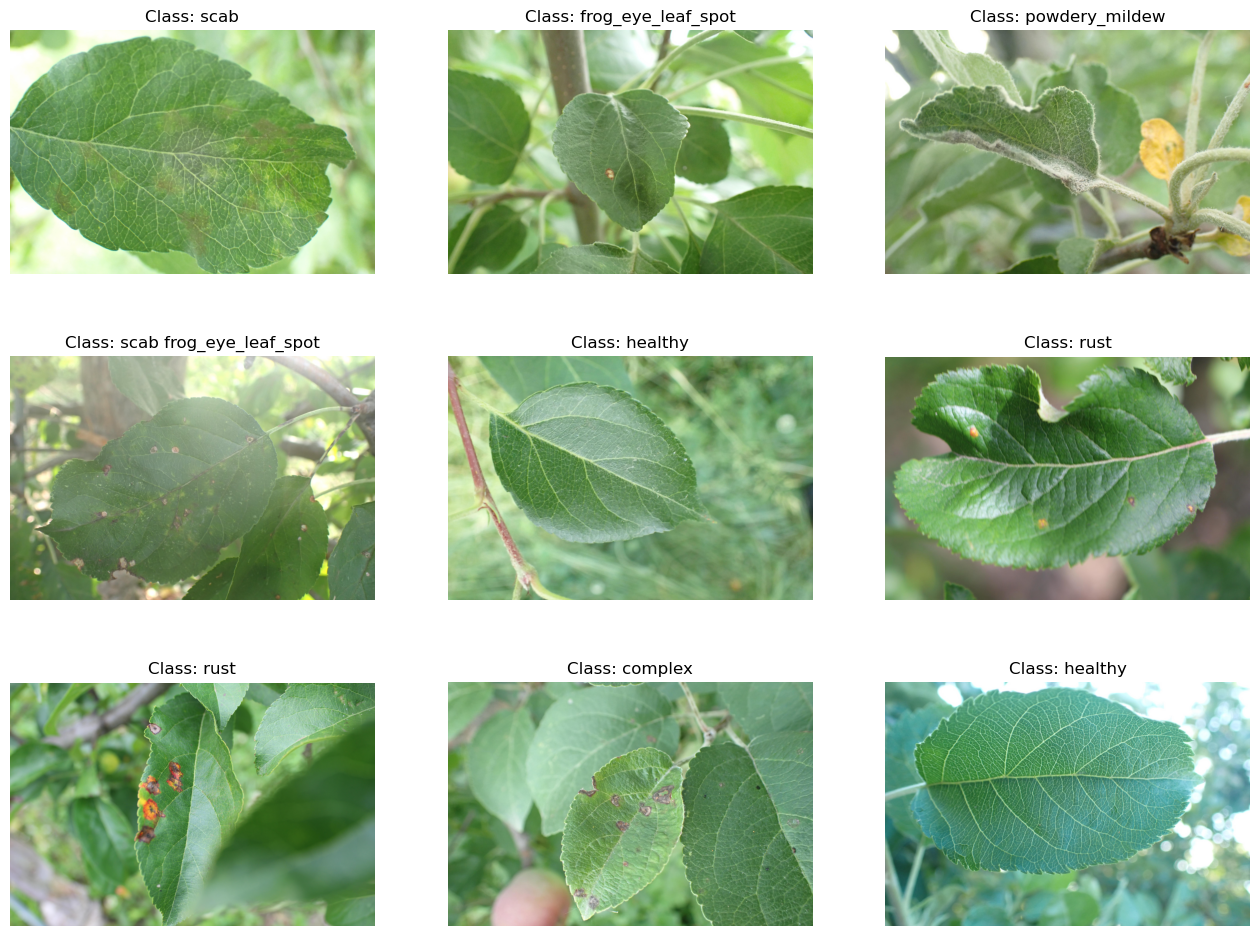

In [28]:
tmp_df = train.sample(9)
image_ids = tmp_df["image"].values
labels = tmp_df["labels"].values
visualize_batch(train_image_path,image_ids,labels)

In [31]:
def load_image(image_id):
    file_path = image_id
    image = cv2.imread(train_image_path+'/'+ file_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Just take 100 sample images with SAMPLE_LEN=100 for RBG Channel Analysis

train_images = train["image"][:100].apply(load_image)

In [32]:
red_values = [np.mean(train_images[idx][:, :, 0]) for idx in range(len(train_images))]
green_values = [np.mean(train_images[idx][:, :, 1]) for idx in range(len(train_images))]
blue_values = [np.mean(train_images[idx][:, :, 2]) for idx in range(len(train_images))]
values = [np.mean(train_images[idx]) for idx in range(len(train_images))]

### 12.3.1 시드값 고정 및 GPU 장비 설정

시드값 고정

In [19]:
import torch
import random
import numpy as np
import os

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False
torch.backends.cudnn.enabled=False

GPU 장비 설정

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 12.3.2 데이터 준비

In [21]:
import pandas as pd

data_path = './input/plant-pathology-2020-fgvc7/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

훈련 데이터, 검증 데이터 분리

In [22]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train, test_size=0.1,
                                stratify=train[['healthy', 'multiple_diseases', 'rust', 'scab']],
                                random_state=42)

데이터셋 클래스 정의

In [23]:
import cv2
from torch.utils.data import Dataset
import numpy as np

class ImageDataset(Dataset):
    def __init__(self, df, img_dir='./', transform=None, is_test=False):
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]
        img_path = self.img_dir + img_id + '.jpg'
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            image = self.transform(image=image)['image']
        # 테스트 데이터이면 이미지 데이터만 반환, 그렇지 않으면 타깃값도 반환
        if self.is_test:
            return image
        
        else:
            # 타깃값 4개 중 가장 큰 값의 인덱스
            label = np.argmax(self.df.iloc[idx, 1:5])
            return image, label

이미지 변환기 정의

In [24]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [25]:
transform_train = A.Compose([
    A.Resize(450, 650),
    #A.Resize(320, 512),
    A.RandomBrightnessContrast(brightness_limit=0.2, # 밝기 대비 조절
                               contrast_limit=0.2, p=0.3),
    A.VerticalFlip(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30, p = 0.3),
    A.OneOf([A.Emboss(p=1), # 양각화, 날카로움, 블러 효과
             A.Sharpen(p=1),
             A.Blur(p=1)], p=0.3),
    A.PiecewiseAffine(p=0.3), # 어파인 변환
    A.Normalize(), # 정규화 변환
    ToTensorV2() # 텐서로 변환
])

In [26]:
transform_test = A.Compose([
    A.Resize(450,650),
    #A.Resize(320, 512),
    A.Normalize(),
    ToTensorV2()
])

데이터셋 및 데이터 로더 생성

In [27]:
img_dir = './input/plant-pathology-2020-fgvc7/images/'

dataset_train = ImageDataset(train, img_dir=img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test)

In [28]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

In [29]:
from torch.utils.data import DataLoader

batch_size = 16

trainloader = DataLoader(dataset_train, batch_size=batch_size,
                          shuffle=True, worker_init_fn = seed_worker,
                          generator=g, num_workers=0)
validloader = DataLoader(dataset_valid, batch_size=batch_size,
                          shuffle=False, worker_init_fn = seed_worker,
                          generator=g, num_workers=0)

### 12.3.3 모델 생성

In [30]:
# !pip install efficientnet-pytorch==0.7.1

In [31]:
model = models.resnet50(pretrained = True)
for param in model.parameters():
    param.require_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs,512,bias=True),
                          nn.ReLU(),
                          nn.Dropout(p=0.3),
                          nn.Linear(512,4, bias = True))

model = model.to(device)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
# from efficientnet_pytorch import EfficientNet

In [33]:
# 사전 훈련된 efficient-b7 모델 불러오기
# model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=4)

# model = model.to(device) # 장비 할당

In [34]:
device

device(type='cuda')

In [35]:
# import torch.nn as nn

# # 사전 훈련된 efficient-b7 모델 불러오기
# model = EfficientNet.from_pretrained('efficientnet-b7')

# # 불러온 efficientnet-b7 모델의 마지막 계층 수정
# model._fc = nn.Sequential(
#                 nn.Linear(model._fc.in_features, model._fc.out_features), # 2560 --> 1000
#                 nn.ReLU(), # 활성화함수
#                 nn.Dropout(p=0.5), # 50% 드롭아웃
#                 nn.Linear(model._fc.out_features, 4) # 1000 --> 4
# )
# model = model.to(device)

### 12.3.4 모델 훈련 및 성능 검증

손실 함수와 옵티마이저 설정

In [36]:
import torch.nn as nn
from torch import optim # 옵티마이저 (경사하강법...)
from transformers import get_cosine_schedule_with_warmup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006, weight_decay=0.0001)

훈련 및 성능 검증

In [37]:
def validation(model, validloader, criterion):
    # 전방향 예측후 나온 점수(logits)의 최대값을 최종 예측으로 준비
    # 이 최종 예측과 정답을 비교
    # 전체 중 맞은 것의 개수 비율을 정확도(accuracy)로 계산
    num_classes = 4
    valid_accuracy = 0
    valid_loss = 0
    preds_auc_list = [] # 예측 확률값 저장용 리스트 초기화
    preds_acc_list = []
    true_list = [] # 실제 타깃값 저장용 리스트 초기화
    true_onehot_list = []
    
    # 전방향 예측을 구할 때는 gradient가 필요가 없음
    with torch.no_grad():
        for images, labels in validloader: # 10000개의 데이터에 대해 100개씩(미니배치 사이즈) 100번을 iterations
            # 1. 입력데이터 준비
            #images.resize_(images.size()[0], 784) # 100, 1, 28, 28
            images = images.to(device)
            labels = labels.to(device)
            
            # 2. 전방향(Forward) 예측 
            # logits = model.forward(images) # 점수 반환
            outputs = model(images)
            # _, preds = torch.max(logits, 1) # 100개에 대한 최종 예측
            
            loss = criterion(outputs, labels) # 100개에 대한 loss
            
            # acc 스코어
            preds_acc = torch.max(outputs.cpu(), dim=1)[1].numpy()
            true = labels.cpu().numpy()
            
            # roc_auc 스코어
            preds_auc = torch.softmax(outputs.cpu(), dim=1).numpy()
            true_onehot = torch.eye(num_classes, device='cuda')[labels].cuda().cpu().numpy()
            
            # ACC와 AUC 스코어 필요 인자가 달라서 각자 계산
            # 왜 이렇게 계산하는지 학습 필요
            preds_acc_list.extend(preds_acc)
            preds_auc_list.extend(preds_auc)
            true_list.extend(true)
            true_onehot_list.extend(true_onehot)
            
            # valid_accuracy += accuracy
            valid_loss += loss.item() # tensor 값을 꺼내옴 
            
    valid_auc = roc_auc_score(true_onehot_list, preds_auc_list)
    vallid_accuracy = accuracy_score(true_list, preds_acc_list)
    return valid_loss, valid_auc, vallid_accuracy # 100세트 전체 대한 총 loss, 총 accuracy

In [38]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm # 진행률 표시 막대
writer  = SummaryWriter()

In [39]:
train_loss_list = []
valid_loss_list = []
val_auc_list = []
val_acc_list = []

In [40]:
def train(model, epochs, criterion, optimizer):
    steps = 0
    min_loss = 10000
    max_accuracy = 0
    trigger = 0
    patience = 5 # for Early stopping
    num_classes = 4
  
    steps_per_epoch = len(trainloader) 
  
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in tqdm(trainloader): # 진행률 막대 표시
            steps += 1
            # 1. 입력 데이터 준비
            images = images.to(device)
            labels = labels.to(device)
            
            # 2. 전방향(Forward) 예측 
            outputs = model(images) # 예측
            loss = criterion(outputs, labels) # 예측과 결과를 통해 Cross Entropy Loss 반환
      
            # 3. 역방향(Backward) 오차(Gradient) 전파
            optimizer.zero_grad() # 파이토치에서 gradient가 누적되지 않게 하기 위해
            loss.backward()
      
            # 4. 경사하강법으로 모델 파라미터 업데이트
            optimizer.step() # W <- W -lr*Gradient
      
            train_loss += loss.item()
        
            if (steps % steps_per_epoch) == 0: # step :.... (epoch 마다)
                model.eval() # 배치 정규화, 드롭아웃이 적용될 때는 model.forward 연산이 training때와 다르므로 반드시 설정
                valid_loss, valid_auc, valid_accuracy = validation(model, validloader, criterion)
        
                # tensorboad 시각화를 위한 로그 이벤트 등록
                writer.add_scalar("Loss/train", train_loss/len(trainloader), epoch)
                writer.add_scalar("Loss/valid", valid_loss/len(validloader), epoch)
                writer.add_scalars("Loss/train and valid",
                                  {'train' : train_loss/len(trainloader),
                                  'valid' : valid_loss/len(validloader)}, epoch)
                
                # writer.add_scalar("Valid Accuracy", valid_accuracy/len(validloader), epoch)
                writer.add_scalar("Valid AUC", valid_auc, epoch)
                writer.add_scalar("Valid ACC", valid_accuracy, epoch)
                
                train_loss_list.append(train_loss/len(trainloader))
                valid_loss_list.append(valid_loss/len(validloader))
                val_acc_list.append(valid_accuracy)
                val_auc_list.append(valid_auc)
                
                print('Epoch : {}/{}...'.format(epoch+1, epochs),
                      'Train Loss : {:.3f} / '.format(train_loss/len(trainloader)),
                      'Valid Loss : {:.3f} / '.format(valid_loss/len(validloader)),
                      'Valid AUC : {:.3f} / '.format(valid_auc),
                      'Valid Accuracy : {:.3f}'.format(valid_accuracy))
              
                if valid_accuracy > max_accuracy: 
                    max_accuracy = valid_accuracy
                    torch.save(model.state_dict(), 'best_checkpoint.pth')
        
                # Early Stopping (조기 종료)
                if valid_loss > min_loss:
                    trigger += 1 # valid loss가 min_loss 를 갱신하지 못할때마다 증가
                    print('trigger : ', trigger )
                    if trigger > patience:
                        print('Early Stopping!!!')
                        print('Traning step is finished!!')
                        writer.flush()  
                        return   
                else:
                    trigger = 0
                    min_loss = valid_loss
        
                train_loss = 0
                model.train()
                scheduler.step()
  
    writer.flush()  

In [41]:
torch.cuda.empty_cache()

In [42]:
epochs=15

In [ ]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

In [43]:
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps = len(trainloader) * 3,
                                            num_training_steps = len(trainloader) * epochs)

In [44]:
# img size 320, 512
train(model, epochs, criterion, optimizer)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch : 1/15... Train Loss : 1.398 /  Valid Loss : 1.397 /  Valid AUC : 0.324 /  Valid Accuracy : 0.322


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch : 2/15... Train Loss : 1.387 /  Valid Loss : 1.377 /  Valid AUC : 0.362 /  Valid Accuracy : 0.322


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch : 3/15... Train Loss : 1.360 /  Valid Loss : 1.342 /  Valid AUC : 0.492 /  Valid Accuracy : 0.322


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch : 4/15... Train Loss : 1.319 /  Valid Loss : 1.296 /  Valid AUC : 0.632 /  Valid Accuracy : 0.322


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch : 5/15... Train Loss : 1.275 /  Valid Loss : 1.247 /  Valid AUC : 0.715 /  Valid Accuracy : 0.432


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch : 6/15... Train Loss : 1.227 /  Valid Loss : 1.185 /  Valid AUC : 0.775 /  Valid Accuracy : 0.661


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch : 7/15... Train Loss : 1.162 /  Valid Loss : 1.091 /  Valid AUC : 0.790 /  Valid Accuracy : 0.689


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch : 8/15... Train Loss : 1.065 /  Valid Loss : 0.958 /  Valid AUC : 0.820 /  Valid Accuracy : 0.754


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch : 9/15... Train Loss : 0.937 /  Valid Loss : 0.807 /  Valid AUC : 0.856 /  Valid Accuracy : 0.858


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch : 10/15... Train Loss : 0.815 /  Valid Loss : 0.688 /  Valid AUC : 0.894 /  Valid Accuracy : 0.891


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch : 11/15... Train Loss : 0.697 /  Valid Loss : 0.566 /  Valid AUC : 0.920 /  Valid Accuracy : 0.907


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch : 12/15... Train Loss : 0.604 /  Valid Loss : 0.481 /  Valid AUC : 0.941 /  Valid Accuracy : 0.907


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch : 13/15... Train Loss : 0.519 /  Valid Loss : 0.398 /  Valid AUC : 0.957 /  Valid Accuracy : 0.929


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch : 14/15... Train Loss : 0.454 /  Valid Loss : 0.343 /  Valid AUC : 0.965 /  Valid Accuracy : 0.929


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch : 15/15... Train Loss : 0.415 /  Valid Loss : 0.315 /  Valid AUC : 0.970 /  Valid Accuracy : 0.923


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


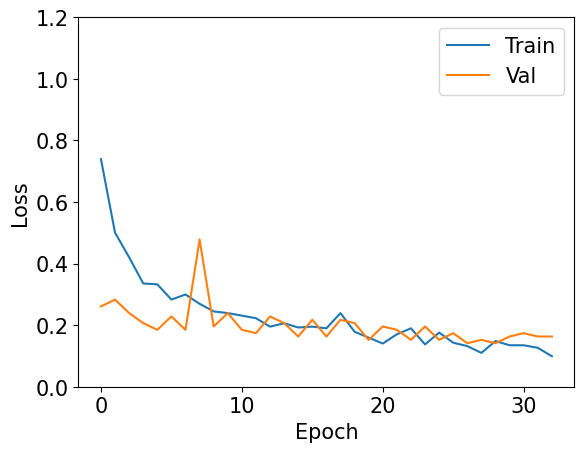

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
plt.ylim(0,1.2)
sns.lineplot(list(range(len(arr_train_loss))), arr_train_loss)
sns.lineplot(list(range(len(arr_valid_loss))), arr_valid_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


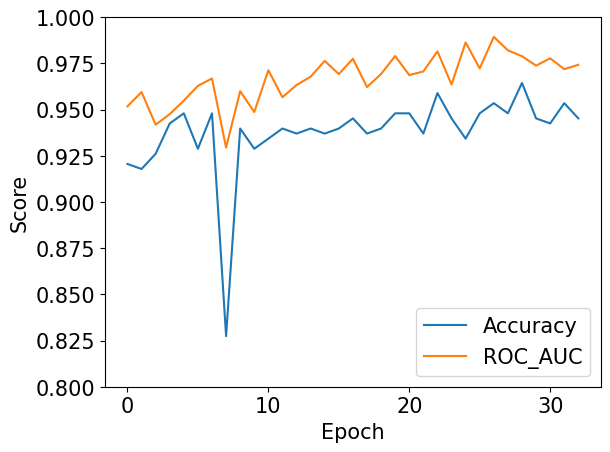

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
plt.ylim(0.8,1)
sns.lineplot(list(range(len(val_acc_list))), val_acc_list)
sns.lineplot(list(range(len(val_auc_list))), val_auc_list)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(['Accuracy','ROC_AUC'])

In [68]:
%load_ext tensorboard

In [44]:
!taskkill /im tensorboard.exe /f
!del /q %TMP%\.tensorboard-info\*

오류: 프로세스 "tensorboard.exe"을(를) 찾을 수 없습니다.


In [69]:
%tensorboard --logdir=runs

In [78]:
writer.close()

### 12.3.5 예측 및 결과 제출

In [45]:
dataset_test = ImageDataset(test, img_dir=img_dir, transform=transform_test, is_test=True)
 
testloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=0)

예측

In [47]:
model.eval() # 모델을 평가 상태로 설정

preds = np.zeros((len(test), 4)) # 예측값 저장용 배열초기화

with torch.no_grad():
    for i, images in enumerate(testloader):
        images = images.to(device)
        outputs = model(images)
        
        # 타깃 예측 확률
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        preds[i*batch_size:(i+1)*batch_size] += preds_part

In [48]:
submission[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds
submission.to_csv('submission.csv', index=False)

## 12.4 성능 개선
1. 에폭 늘리기
2. 스케줄러 추가
3. TTA(테스트 단계 데이터 증강) 기법
4. 레이블 스무딩 적용

### 12.4.1 모델 훈련 및 성능 검증

스케줄러 변경 및 에폭증강

In [64]:
from transformers import get_cosine_schedule_with_warmup
epochs = 20
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps = len(trainloader) * 3,
                                            num_training_steps = len(trainloader) * epochs)

In [65]:
def train(model, epochs, criterion, optimizer):
    steps = 0
    min_loss = 10000
    max_accuracy = 0
    trigger = 0
    patience = 5 # for Early stopping
    num_classes = 4
  
    steps_per_epoch = len(trainloader) 
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in tqdm(trainloader): # 이터레이터로부터 미니배치 16개씩을 가져와 images, labels에 준비
            steps += 1
            # 1. 입력 데이터 준비
            images = images.to(device)
            labels = labels.to(device)
            
            # 2. 전방향(Forward) 예측 
            outputs = model(images) # 예측
            loss = criterion(outputs, labels) # 예측과 결과를 통해 Cross Entropy Loss 반환
      
            # 3. 역방향(Backward) 오차(Gradient) 전파
            optimizer.zero_grad() # 파이토치에서 gradient가 누적되지 않게 하기 위해
            loss.backward()
      
            # 4. 경사하강법으로 모델 파라미터 업데이트
            optimizer.step() # W <- W -lr*Gradient
      
            train_loss += loss.item()
        
            if (steps % steps_per_epoch) == 0: # step : 3125, .... (epoch 마다)
                model.eval() # 배치 정규화, 드롭아웃이 적용될 때는 model.forward 연산이 training때와 다르므로 반드시 설정
                valid_loss, valid_auc, valid_accuracy = validation(model, validloader, criterion)
        
                # tensorboad 시각화를 위한 로그 이벤트 등록
                writer.add_scalar("Loss/train", train_loss/len(trainloader), epoch)
                writer.add_scalar("Loss/valid", valid_loss/len(validloader), epoch)
                writer.add_scalars("Loss/train and valid",
                                  {'train' : train_loss/len(trainloader),
                                  'valid' : valid_loss/len(validloader)}, epoch)
                
                # writer.add_scalar("Valid Accuracy", valid_accuracy/len(validloader), epoch)
                writer.add_scalar("Valid AUC", valid_auc, epoch)
        
                print('Epoch : {}/{}.....'.format(epoch+1, epochs),
                      'Train Loss : {:.3f}'.format(train_loss/len(trainloader)),
                      'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)),
                      'Valid AUC : {:.3f}'.format(valid_auc),
                      'Valid Accuracy : {:.3f}'.format(valid_accuracy))
              
                if valid_auc > max_accuracy: 
                    max_accuracy = valid_auc
                    torch.save(model.state_dict(), 'best_checkpoint.pth')
        
                # Early Stopping (조기 종료)
                if valid_loss > min_loss:
                    trigger += 1 # valid loss가 min_loss 를 갱신하지 못할때마다 증가
                    print('trigger : ', trigger )
                    if trigger > patience:
                        print('Early Stopping!!!')
                        print('Traning step is finished!!')
                        writer.flush()  
                        return   
                else:
                    trigger = 0
                    min_loss = valid_loss
        
                train_loss = 0
                model.train()
                scheduler.step()
  
    writer.flush()  

훈련 및 성능 검증

In [66]:
torch.cuda.empty_cache()

In [ ]:
epochs = 20
train(model, epochs, criterion, optimizer)

  0%|          | 0/364 [00:00<?, ?it/s]

Epoch : 1/20..... Train Loss : 0.043 Valid Loss : 0.189 Valid AUC : 0.977


  0%|          | 0/364 [00:00<?, ?it/s]

Epoch : 2/20..... Train Loss : 0.037 Valid Loss : 0.186 Valid AUC : 0.981


  0%|          | 0/364 [00:00<?, ?it/s]

In [ ]:
%reload_ext tensorboard

In [62]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 11368), started 2:31:01 ago. (Use '!kill 11368' to kill it.)

In [58]:
dataset_test = ImageDataset(test, img_dir=img_dir, transform=transform_test, is_test=True)

loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g, num_workers=0)

dataset_TTA = ImageDataset(test, img_dir=img_dir, transform=transform_train, is_test=True)

loader_TTA = DataLoader(dataset_TTA, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g, num_workers=0)

예측

- 테스트 데이터 원본으로 예측한 타깃값

In [55]:
model.eval()

preds_test = np.zeros((len(test), 4))

with torch.no_grad():
    for i, images in enumerate(testloader):
        images = images.to(device)
        outputs = model(images)
        
        # 타깃 예측 확률
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        preds_test[i*batch_size:(i+1)*batch_size] += preds_part

In [ ]:
alpha = 0.001
threshold = 0.999

submission_test_ls = submission_test.copy()
submission_tta_ls = submission_tta.copy()

target = ['healthy', 'multiple_diseases', 'rust', 'scab']

submission_test_ls[target] = apply_label_smoothing(submission_test_ls, target, alpha, threshold)

submission_tta_ls[target] = apply_label_smoothing(submission_tta_ls, target, alpha, threshold)

submission_test_ls.to_csv('submission_test_ls.csv', index=False)
submission_tta_ls.to_csv('submission_tta_ls.csv', index=False)